In [1]:
import os
import json
import pandas as pd

import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [3]:
file_path = "turl_test_2k_prompts_50.jsonl"
device = torch.device("mps")

model_name = "osunlp/TableLlama"
config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)

In [3]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [4]:
!ls -larth "/Volumes/ssd/uncertainty/tablellama su 1800 prompts/"

total 37203968
drwx------  1 bono  staff   1.0M Feb 17 08:52 ..
-rwx------@ 1 bono  staff   4.4G Mar  7 12:23 TableLlama.1548780410.pickle
drwx------  1 bono  staff   1.0M Mar  7 14:45 .
-rwx------  1 bono  staff   4.0K Mar  7 14:46 ._TableLlama.1548780410.pickle
-rwx------@ 1 bono  staff   4.4G Mar  8 14:55 TableLlama.2573653229.pickle
-rwx------  1 bono  staff   4.0K Mar  8 14:56 ._TableLlama.2573653229.pickle
-rwx------@ 1 bono  staff   4.4G Mar  9 10:21 TableLlama.1765523202.pickle
-rwx------  1 bono  staff   4.0K Mar  9 10:27 ._TableLlama.1765523202.pickle
-rwx------@ 1 bono  staff   4.4G Mar 10 08:18 TableLlama.940523022.pickle
-rwx------  1 bono  staff   4.0K Mar 10 08:35 ._TableLlama.940523022.pickle


In [7]:
%%time

# load processed data

import os
import pickle

prefix = '/Volumes/ssd/uncertainty/tablellama su 1800 prompts/'

run = 0

outlist = []
for file in os.listdir(prefix):
    if file.endswith('pickle') and not file.startswith('.'):
        print(file)
        with open(os.path.join(prefix, file), 'rb') as handle:
            outlist_ = pickle.load(handle)
           
            for pid, o in enumerate(outlist_):
                del o['pre_output_proba_topn']
                del o['pre_output_proba_topk']
                del o['pre_output_true_entropies']
                del o['post_output_proba_topn']
                del o['post_output_proba_topk']
                del o['post_output_true_entropies']
                o['run'] = run
                o['pid'] = pid
                outlist.append(o)
        run += 1

len(outlist)

TableLlama.1548780410.pickle
TableLlama.1765523202.pickle
TableLlama.2573653229.pickle
TableLlama.940523022.pickle
CPU times: user 1min 58s, sys: 49.7 s, total: 2min 48s
Wall time: 2min 59s


7204

In [5]:
import pickle

if False:
    with open('1800.pickle', 'wb') as handle:
        pickle.dump(outlist, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('1800.pickle', 'rb') as handle:
        outlist = pickle.load(handle)

In [6]:
len(outlist)

7204

### check outputs against ground truth

In [7]:
%%time

# show results

c=0
t=0
h=0

truth = []

for idx, p in enumerate(outlist):
    print(idx, end='\r')
    c+=1
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    a = generated_text.lower().strip()
    b = p['output'].lower().strip()
    # correct
    correct = False
    if (a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')
        
    truth.append((p['run'], p['pid'], correct))

Token indices sequence length is longer than the specified maximum sequence length for this model (4857 > 4096). Running this sequence through the model will result in indexing errors


CPU times: user 1min 8s, sys: 2.28 s, total: 1min 11s
Wall time: 1min 15s


In [8]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct'])

In [9]:
truth.groupby('pid').size().value_counts()

4    1801
Name: count, dtype: int64

<Axes: xlabel='correct', ylabel='Count'>

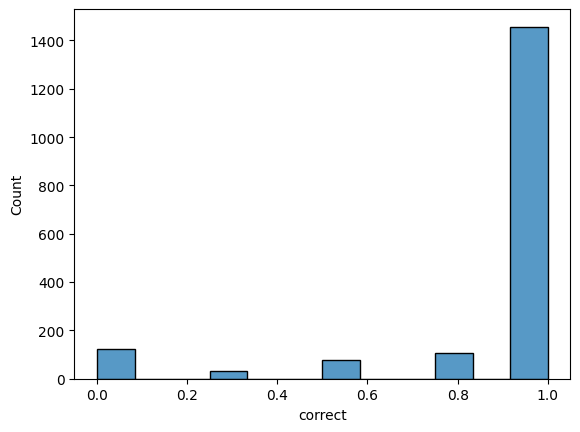

In [10]:
import seaborn as sns
sns.histplot(truth.groupby('pid').correct.mean())

In [11]:
accu = truth.groupby('pid').correct.mean()

In [12]:
accu[accu<1.].shape

(344,)

In [13]:
accu[accu<1.].value_counts()

correct
0.00    125
0.75    107
0.50     78
0.25     34
Name: count, dtype: int64

In [14]:
# all prompts with errors plus a sample of noerrors
err_idx = accu[accu<1.].index.tolist()
noerr_idx = accu[accu==1.].sample(len(accu[accu<1.]), random_state=42).index.tolist()

In [15]:
set(err_idx) & set(noerr_idx)

set()

In [16]:
selected_pids = set(err_idx) | set(noerr_idx)
len(selected_pids)

688

In [17]:
%%time

# load processed data

import os
import pickle

prefix = '/Volumes/ssd/uncertainty/tablellama su 1800 prompts/'

run = 0

outlist = []
for file in os.listdir(prefix):
    if file.endswith('pickle') and not file.startswith('.'):
        print(file)
        with open(os.path.join(prefix, file), 'rb') as handle:
            outlist_ = pickle.load(handle)
           
            for pid, o in enumerate(outlist_):
                if pid in selected_pids:
                    o['run'] = run
                    o['pid'] = pid
                    outlist.append(o)
        run += 1

len(outlist)

TableLlama.1548780410.pickle
TableLlama.1765523202.pickle
TableLlama.2573653229.pickle
TableLlama.940523022.pickle
CPU times: user 2min 20s, sys: 2min 3s, total: 4min 23s
Wall time: 5min 10s


2752

In [60]:
outlist[0].keys()

dict_keys(['table', 'cell', 'instruction', 'input', 'question', 'output', 'pre_output_proba_topn', 'pre_output_proba_topk', 'pre_output_true_entropies', 'post_output_sequences', 'post_output_proba_topn', 'post_output_proba_topk', 'post_output_true_entropies', 'elapsed', 'run', 'pid'])

In [18]:
outlist[-1]['run']

3

In [19]:
import pickle
with open('644.data.pickle', 'wb') as handle:
    pickle.dump(outlist, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
!ls -larth

total 43159720
-rw-r--r--@  1 bono  staff    15M May 14  2024 turl_test_2k_prompts_50.jsonl
-rw-r--r--   1 bono  staff    17B Feb 10 10:37 README.md
-rwx------@  1 bono  staff   4.8K Feb 19 14:05 runner.py
-rw-r--r--   1 bono  staff   137M Feb 19 16:32 gemma-2-2b-it.3892595837.pickle
-rw-r--r--@  1 bono  staff   5.0K Feb 20 09:23 prompt100.py
-rw-r--r--   1 bono  staff    16M Feb 20 20:07 tablellama.preprocessed.pickle
-rw-r--r--@  1 bono  staff   5.2K Feb 20 21:04 prompt100tablellama.py
-rw-r--r--   1 bono  staff   117M Feb 22 09:11 gemma-2-9b-it-4bit.3246737286.pickle
drwxr-xr-x   4 bono  staff   128B Feb 27 07:56 mirror
drwxr-xr-x@ 11 bono  staff   352B Feb 27 08:19 ..
-rw-r--r--@  1 bono  staff   5.3K Mar  2 14:55 prompt100gemmalocal.py
-rw-r--r--   1 bono  staff   222K Mar  4 13:37 jensension.ipynb
drwxr-xr-x   4 bono  staff   128B Mar  5 20:03 older tablellama
drwxr-xr-x  12 bono  staff   384B Mar  6 15:38 tablellama10runs
-rw-r--r--   1 bono  staff   450K Mar  6 16:03 tablellama

### DELETE ME

In [1]:
import pickle
with open('./644sample/644.data.pickle', 'rb') as handle:
    selected = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: './644sample/644.data.pickle'

In [5]:
len(selected)

2752

In [8]:
688*4

2752

In [9]:
%%time
selected_pids = set([s['pid'] for s in selected])

CPU times: user 3.22 ms, sys: 1.83 ms, total: 5.05 ms
Wall time: 5.1 ms


In [14]:
import pickle
with open('selected_pids.688.pickle', 'wb') as handle:
    pickle.dump(selected_pids, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
!ls -larth

total 3810400
-rw-r--r--@  1 bono  staff    15M May 14  2024 turl_test_2k_prompts_50.jsonl
-rw-r--r--   1 bono  staff    17B Feb 10 10:37 README.md
-rwx------@  1 bono  staff   4.8K Feb 19 14:05 runner.py
-rw-r--r--   1 bono  staff   137M Feb 19 16:32 gemma-2-2b-it.3892595837.pickle
-rw-r--r--@  1 bono  staff   5.0K Feb 20 09:23 prompt100.py
-rw-r--r--   1 bono  staff    16M Feb 20 20:07 tablellama.preprocessed.pickle
-rw-r--r--@  1 bono  staff   5.2K Feb 20 21:04 prompt100tablellama.py
-rw-r--r--   1 bono  staff   117M Feb 22 09:11 gemma-2-9b-it-4bit.3246737286.pickle
drwxr-xr-x   4 bono  staff   128B Feb 27 07:56 mirror
drwxr-xr-x@ 11 bono  staff   352B Feb 27 08:19 ..
-rw-r--r--@  1 bono  staff   5.3K Mar  2 14:55 prompt100gemmalocal.py
-rw-r--r--   1 bono  staff   222K Mar  4 13:37 jensension.ipynb
drwxr-xr-x   4 bono  staff   128B Mar  5 20:03 older tablellama
drwxr-xr-x  12 bono  staff   384B Mar  6 15:38 tablellama10runs
-rw-r--r--   1 bono  staff   450K Mar  6 16:03 tablellama-

### debug (transition scores)

In [3]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import os
import time

# run params
temperature=1.0
top_p=0.9
max_new_tokens=128
use_cache=True
device = "mps"

model_name = "osunlp/TableLlama"

# load inputs
file_path = "turl_test_2k_prompts_50.jsonl"
device = torch.device(device)

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device)
model.resize_token_embeddings(32001)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)
model.eval()

# build prompts
PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# p = prompts[742] # 742 is shortest
p = prompts[840] # average joe

In [5]:
%%time

prompt = generate_prompt(p["instruction"], p["question"], p["input"])
inputs = tokenizer(prompt, return_tensors="pt").to(device)
with torch.no_grad():
    pre_output = model(**inputs, use_cache=use_cache)
pre_output = pre_output.logits.cpu().detach()

CPU times: user 221 ms, sys: 498 ms, total: 719 ms
Wall time: 3.04 s


In [6]:
%%time

post_output = model.generate(
    **inputs,
    max_new_tokens=max_new_tokens,
    temperature=temperature,
    top_p=top_p,
    output_scores=True,
    return_dict_in_generate=True,
    output_logits=True,
    use_cache=use_cache
    )

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


CPU times: user 1.87 s, sys: 945 ms, total: 2.82 s
Wall time: 5.5 s


In [7]:
transition_scores = model.compute_transition_scores(post_output.sequences, post_output.scores, normalize_logits=True)

In [8]:
post_output.sequences.shape, len(post_output.scores), post_output.scores[0].shape, transition_scores.shape

(torch.Size([1, 1094]), 21, torch.Size([1, 32001]), torch.Size([1, 21]))

In [9]:
post_output.scores[0].shape

torch.Size([1, 32001])

In [10]:
transition_scores[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='mps:0')

In [11]:
log_likelihoods = [score.item() for score in transition_scores[0]]

In [13]:
log_likelihoods

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [14]:
transition_scores_s = model.compute_transition_scores(post_output.sequences, post_output.scores, normalize_logits=True)
log_likelihoods_s = [score.item() for score in transition_scores[0]]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [15]:
transition_scores

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='mps:0')

In [16]:
transition_scores_l = model.compute_transition_scores(post_output.sequences, post_output.logits, normalize_logits=True)
log_likelihoods_l = [score.item() for score in transition_scores[0]]

[-4.768370445162873e-07,
 -0.09085541218519211,
 -0.10185058414936066,
 -4.768370445162873e-07,
 -1.1920928244535389e-07,
 -2.407998726994265e-05,
 -0.0023836076725274324,
 0.0,
 0.0,
 -0.022649873048067093,
 -0.007525428663939238,
 -9.536738616588991e-07,
 -3.576278118089249e-07,
 0.0,
 -2.3841855067985307e-07,
 0.0,
 -3.2186455882765586e-06,
 -7.867782187531702e-06,
 -5.960462772236497e-07,
 -1.1920928244535389e-07,
 0.0]

In [17]:
transition_scores

tensor([[-4.7684e-07, -9.0855e-02, -1.0185e-01, -4.7684e-07, -1.1921e-07,
         -2.4080e-05, -2.3836e-03,  0.0000e+00,  0.0000e+00, -2.2650e-02,
         -7.5254e-03, -9.5367e-07, -3.5763e-07,  0.0000e+00, -2.3842e-07,
          0.0000e+00, -3.2186e-06, -7.8678e-06, -5.9605e-07, -1.1921e-07,
          0.0000e+00]], device='mps:0')